In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c

import iminuit 
from iminuit import Minuit, cost
import ROOT

import mplhep as hep
mpl.style.use(hep.style.ATLAS)


Welcome to JupyROOT 6.24/02


Analisi per ottenere valore di $\gamma$. Conosciamo la relazione di fit che è $$ I = \alpha\cdot V^{\frac{4\gamma-1}{4\gamma+1}} $$

In [2]:
V, μ_I, σ_I = np.loadtxt('dati_offline_prelim/lamp.txt', unpack=True)

def f(V, α, γ):
    return α*(V**((4*γ-1)/(4*γ+1)))

χ2= cost.LeastSquares(V, μ_I, σ_I, model=f)

m_γ = Minuit(χ2, α=1e-2, γ=0.8)
m_γ.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.791e+04 (chi2/ndof = 182.7)│              Nfcn = 61               │
│ EDM = 5.43e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │11.9805e-3 │ 0.0027e-3 │            │            │         │         │       │
│ 1 │ γ    │ 877.69e-3 │  0.24e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         α         γ │
├───┼─────────────────────┤
│ α │  7.22e-12 -6.12e-10 │
│ γ │ -6.12e-10  5.68e-08 │
└───┴─────────────────────┘

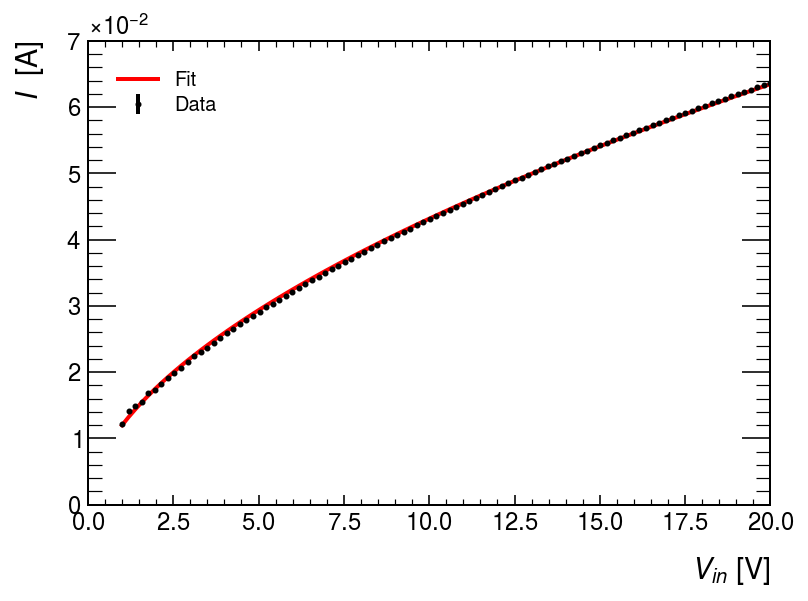

In [3]:
fig, ax = plt.subplots()

ax.set_xlabel('$V_{in}$ [V]')
ax.set_ylabel('$I$  [A]')
ax.errorbar(V, μ_I, σ_I, fmt='k.', markersize=4, label='Data')
ax.plot(V, f(V, *m_γ.values), 'r', label='Fit')
ax.legend()

In [6]:
fig.savefig('report/fig/gamma_plot.pdf', bbox_inches='tight')

In [7]:
γ, σ_γ = m_γ.values['γ'], m_γ.errors['γ']

from uncertainties import ufloat
print(f'γ = {ufloat(γ, σ_γ):.3uS}')

σ_γ/γ

γ = 0.877687(238)


0.0002715560568118119

In [42]:

V, μ_I, σ_I, μ_Vfd, σ_Vfd = np.loadtxt('dati_offline_prelim/ph_diode.txt', unpack=True)

T_amb = 299.7
σ_T_amb = 0.7
R_amb, σ_R_amb = 25.045, 0.21551350000000002

ν, σ_ν = c/450e-9, c/(450e-9**2) * 10e-9 / (2 * np.log(2 + np.sqrt(3)))

def log_0j(V0, Vi):
    return np.log(Vi/V0)

def T_0j(T0, Ti, ν):
    return ν*(1/T0-1/Ti)

def T(T_amb, R_amb, V, I, γ):
    return T_amb * ( V/(I*R_amb) )**γ

μ_T = T(T_amb, R_amb, V, μ_I, γ)

LOG = np.array([
    log_0j(μ_Vfd[0], μ_Vfdi) for μ_Vfdi in μ_Vfd
])

TEMP_DIFF =  np.array([
    T_0j(μ_T[0], μ_Ti, ν) for μ_Ti in μ_T
])




In [43]:

σ_LOG = np.zeros_like(LOG)

for i in range(len(LOG)):
    σ2 = 0.0
    σ_Vi_p = np.abs(log_0j(μ_Vfd[0], μ_Vfd[i] + σ_Vfd[i]) - LOG[i])
    σ_Vi_n = np.abs(log_0j(μ_Vfd[0], μ_Vfd[i] - σ_Vfd[i]) - LOG[i])
    σ2 += np.max([σ_Vi_p, σ_Vi_n])**2
    
    σ_LOG[i] += np.sqrt(σ2)


In [44]:


f_hk = ROOT.TF1('f_hk', '[0]*x + [1]')
f_hk.SetParameters(4e-11, 0.)

g_hk0 = ROOT.TGraphErrors(len(LOG), TEMP_DIFF.ravel(), LOG.ravel(), np.zeros_like(TEMP_DIFF).ravel(), σ_LOG.ravel())
g_hk0.Fit('f_hk', 'S')

μ_hk_bias = f_hk.GetParameter(0)
σ_hk_bias = f_hk.GetParError(0)

print(f'h/k = {ufloat(μ_hk_bias, σ_hk_bias):.3uS}\n')

relative_uncertainty = σ_hk_bias / μ_hk_bias
relative_uncertainty

h/k = 3.266141(257)e-11



7.8736129324078e-05

 FCN=148712 FROM MIGRAD    STATUS=CONVERGED      39 CALLS          40 TOTAL
                     EDM=2.36032e-16    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.26614e-11   2.57163e-15   1.84842e-16  -1.96815e+06
   2  p1          -1.66721e-02   7.25809e-05   5.21693e-06  -3.62617e-04


In [54]:


def hk_sigma(_T_amb, _R_amb, _μ_I, _γ,  _ν, _μ_Vfd, _V, hk_true):
    
    def _log_0j(_V0, _Vi):
        return np.log(_Vi/_V0)

    def _T_0j(_T0, _Ti, _ν):
        return _ν*(1/_T0-1/_Ti)

    def _T(_T_amb, _R_amb, _V, _I, _γ):
        return _T_amb * ( _V/(_I*_R_amb) )**_γ

    _μ_T = _T(_T_amb, _R_amb, _V, _μ_I, _γ)

    _LOG = np.array([
        _log_0j(_μ_Vfd[0], _μ_Vfdi) for _μ_Vfdi in _μ_Vfd
    ])

    _TEMP_DIFF =  np.array([
        _T_0j(_μ_T[0], _μ_Ti, _ν) for _μ_Ti in _μ_T
    ])

    
    _f_hk = ROOT.TF1('_f_hk', '[0]*x + [1]')
    _f_hk.SetParameters(4e-11, 0.)

    _g_hk0 = ROOT.TGraphErrors(len(LOG), _TEMP_DIFF.ravel(), _LOG.ravel(), np.zeros_like(_TEMP_DIFF).ravel(), σ_LOG.ravel())
    _g_hk0.Fit('_f_hk', 'S')
    
    _σ_hk_bias = _f_hk.GetParameter(0)
    
    return np.abs(_σ_hk_bias - hk_true)

In [55]:
## Testing linearity for single parameters (T_amb, R_amb, γ, ν)

s_T_amb_p = hk_sigma(T_amb + σ_T_amb, R_amb, μ_I, γ, ν, μ_Vfd, V, μ_hk_bias)
s_T_amb_n = hk_sigma(T_amb - σ_T_amb, R_amb, μ_I, γ, ν, μ_Vfd, V, μ_hk_bias)


s_R_amb_p = hk_sigma(T_amb, R_amb + σ_R_amb, μ_I, γ, ν, μ_Vfd, V, μ_hk_bias)
s_R_amb_n = hk_sigma(T_amb, R_amb - σ_R_amb, μ_I, γ, ν, μ_Vfd, V, μ_hk_bias)

s_ν_p = hk_sigma(T_amb, R_amb, μ_I, γ, ν + σ_ν, μ_Vfd, V, μ_hk_bias)
s_ν_n = hk_sigma(T_amb, R_amb, μ_I, γ, ν - σ_ν, μ_Vfd, V, μ_hk_bias)

s_γ_p = hk_sigma(T_amb, R_amb, μ_I, γ + σ_γ, ν, μ_Vfd, V, μ_hk_bias)
s_γ_n = hk_sigma(T_amb, R_amb, μ_I, γ - σ_γ, ν, μ_Vfd, V, μ_hk_bias)


(s_T_amb_p, s_T_amb_n), (s_R_amb_p, s_R_amb_n), (s_ν_p, s_ν_n), (s_γ_p, s_γ_n)

((7.628625171784221e-14, 7.628625171692456e-14),
 (2.4470025334694855e-13, 2.4868623168992586e-13),
 (2.7325733471594883e-13, 2.7790748608392226e-13),
 (1.1247034691713625e-14, 1.1240761521742903e-14))

 FCN=148712 FROM MIGRAD    STATUS=CONVERGED      41 CALLS          42 TOTAL
                     EDM=7.10716e-15    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.27377e-11   2.57764e-15   1.85274e-16  -1.17814e+06
   2  p1          -1.66721e-02   7.25809e-05   5.21693e-06   1.60388e-03
 FCN=148712 FROM MIGRAD    STATUS=CONVERGED      39 CALLS          40 TOTAL
                     EDM=1.77974e-16    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.25851e-11   2.56563e-15   1.84411e-16   3.55097e+06
   2  p1          -1.66721e-02   7.25809e-05   5.21693e-06  -1.39468e-04
 FCN=148712 FROM MIGRAD    STATUS=CONVERGED      41 CALLS          42 TOTAL
                     EDM=1.70298